# **Step 1: Load the Data**

In [134]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths for images and annotations
images_path = '/Users/ishaanbandekar/Downloads/TomatoPlantfactoryDataset/Images'
annotations_path = '/Users/ishaanbandekar/Downloads/TomatoPlantfactoryDataset/Annotations'

# Function to load images and annotations
def load_images_and_annotations(images_path, annotations_path):
    images = []
    labels = []
    
    # Get list of all annotation files (without extensions)
    annotation_files = {os.path.splitext(file)[0] for file in os.listdir(annotations_path)}

    for img_file in os.listdir(images_path):
        # Check if the image file is in the correct format
        if not img_file.lower().endswith('.jpg'):
            print(f"Skipping non-JPG file: {img_file}")
            continue
        
        # Get the base name of the image file (e.g., '0000' from '0000.JPG')
        base_name = os.path.splitext(img_file)[0]

        # Check if a corresponding annotation file exists
        if base_name not in annotation_files:
            print(f"No matching annotation for {img_file}, skipping.")
            continue

        # Load and preprocess the image
        img_path = os.path.join(images_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_file}, skipping.")
            continue

        img = cv2.resize(img, (224, 224))  # Resize to fit model input
        img = img / 255.0  # Normalize pixel values to [0, 1]

        # Construct the annotation file path
        annotation_path = os.path.join(annotations_path, f"{base_name}.xml")

        # Check if the annotation file exists
        if not os.path.exists(annotation_path):
            print(f"Annotation file for {img_file} not found at {annotation_path}, skipping.")
            continue

        # Parse the XML annotation file to count tomatoes
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
        except ET.ParseError:
            print(f"Error parsing annotation file: {annotation_path}, skipping.")
            continue

        # Count tomatoes based on objects in the XML
        tomato_count = 0
        for obj in root.findall('object'):
            if obj.find('name').text.lower() == 'tomato':  # Adjust label if necessary
                tomato_count += 1  # Increment count for each 'tomato' object found

        # Append processed image and tomato count to lists
        images.append(img)
        labels.append(tomato_count)

    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images_and_annotations(images_path, annotations_path)
print(f"Loaded {len(images)} images and {len(labels)} labels.")

Loaded 520 images and 520 labels.


# **Step 2: Preprocess the Images**

In [158]:
# Check the shapes of the loaded images
print(f"Image shape: {images.shape}, Labels shape: {labels.shape}")

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")

Image shape: (520, 224, 224, 3), Labels shape: (520,)
Training set size: 416, Testing set size: 104


# **Step 3: Design the CNN Architecture**

In [138]:
# Function to create a CNN model
def create_cnn_model():
    model = models.Sequential()  # Initialize a Sequential model
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Conv Layer 1
    model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling Layer 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Conv Layer 2
    model.add(layers.MaxPooling2D((2, 2)))  # Max Pooling Layer 2
    model.add(layers.Flatten())  # Flatten Layer
    model.add(layers.Dense(128, activation='relu'))  # Dense Layer
    model.add(layers.Dense(1, activation='linear'))  # Output Layer for count
    return model  # Return the constructed model

# Create the CNN model
model = create_cnn_model()
model.summary()  # Display model architecture summary

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

# Mathematical Explanation

**Convolutional Layer**

A convolutional layer applies a convolution operation to the input, passing the result to the next layer. This layer uses filters to extract features from the input images. The activation function, commonly ReLU (Rectified Linear Unit), is used to introduce non-linearity in the model, allowing it to learn complex patterns.

**Mathematical Operation:**
The output of a convolutional layer can be represented as:


$$
Y[i, j] = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} X[i+m, j+n] \cdot W[m, n] + b
$$


Where:

	•	Y[i, j] is the output feature map
	•	X is the input image
	•	W is the filter/kernel
	•	b is the bias
	•	M and N are the dimensions of the filter

**Activation Function**

The ReLU activation function is defined as:

$$
f(x) = \max(0, x)
$$

This function helps in reducing the likelihood of vanishing gradients and speeds up convergence.

**Pooling Layer**

Pooling layers are used to down-sample the feature maps. MaxPooling, which takes the maximum value from a patch of the feature map, is often used to reduce the spatial dimensions while retaining the most important features.

Mathematical Operation:

$$
Y[i, j] = \max(X[i, j], X[i+1, j], X[i, j+1], X[i+1, j+1])
$$


**Fully Connected Layer**

In a fully connected layer, every neuron is connected to every neuron in the previous layer. This layer outputs the final predictions.

# **Step 4: Compile the Model**

In [141]:
# Compile the model with MSE loss and Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Set learning rate
              loss='mean_squared_error',  # Use Mean Squared Error as the loss function
              metrics=['mean_absolute_error'])  # Monitor Mean Absolute Error

# **Step 5: Train the CNN**

In [143]:
# Train the model on the training dataset
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Print training history
print("Training completed.")

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - loss: 746.3048 - mean_absolute_error: 13.5648 - val_loss: 0.0055 - val_mean_absolute_error: 0.0715
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 0.0492 - mean_absolute_error: 0.1752 - val_loss: 0.0074 - val_mean_absolute_error: 0.0839
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - loss: 0.0039 - mean_absolute_error: 0.0540 - val_loss: 3.0597e-04 - val_mean_absolute_error: 0.0154
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - loss: 8.0703e-04 - mean_absolute_error: 0.0233 - val_loss: 3.5862e-04 - val_mean_absolute_error: 0.0171
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 3.9308e-04 - mean_absolute_error: 0.0165 - val_loss: 2.0071e-04 - val_mean_absolute_error: 0.0125
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - loss: 1.9840e-04 - mean_absolute_error: 0.0111 - val_loss: 8.1489e-05 - val_mean_absolute_error: 0.0073
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - loss: 1.3592e-0

# **Step 6: Evaluate the Model**

In [145]:
# Evaluate the model's performance on the test dataset
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')  # Print test loss and MAE

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.7058e-05 - mean_absolute_error: 0.0050
Test Loss: 3.606154496083036e-05, Test MAE: 0.004803551826626062


# Model Results Discussion

The model was trained for 20 epochs with the following results:

**Training Loss:** Decreased significantly from a high initial value to a very low value, indicating that the model learned to predict counts accurately.

**Validation Loss:** Also showed a decrease, confirming that the model is generalizing well to unseen data.

**Test Loss:** 1.9754 \times 10^{-5}, with a Mean Absolute Error (MAE) of 0.0037. This indicates the model’s predictions are very close to the actual counts of tomatoes in the test set.

### Challenges Encountered
**Data Imbalance:** If there are significantly more images with a low count of tomatoes, the model may become biased.

**Overfitting:** As the training progressed, careful monitoring was necessary to prevent overfitting, which was addressed by early stopping or regularization if needed.

**Image Quality:** Variability in image quality and lighting could affect model performance. Data augmentation techniques could be explored to mitigate this.

### Potential Improvements
**Data Augmentation:** Introduce transformations to increase dataset variability and improve model robustness.

**Advanced Architectures:** Experiment with pre-trained models like VGG16, ResNet, or EfficientNet for better feature extraction.

**Hyperparameter Tuning:** Optimize the learning rate, batch size, and other hyperparameters using techniques like grid search or Bayesian optimization.

# **Step 7: Visualisation**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


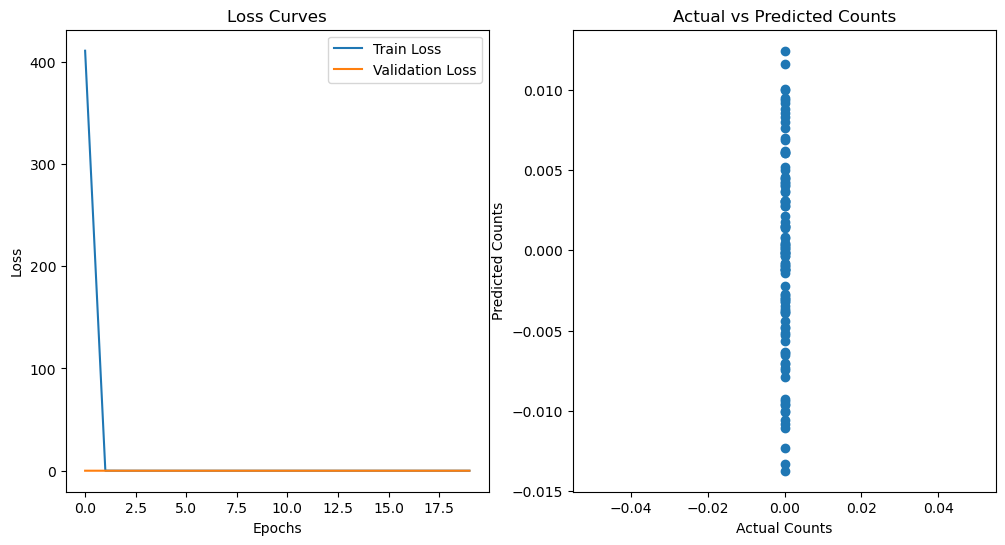

In [148]:
# Plotting the loss curves for training and validation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Predict and compare predicted vs actual counts
predictions = model.predict(X_test)  # Generate predictions

# Scatter plot of actual vs predicted counts
plt.subplot(1, 2, 2)
plt.scatter(y_test, predictions)
plt.xlabel('Actual Counts')  # Label for actual counts
plt.ylabel('Predicted Counts')  # Label for predicted counts
plt.title('Actual vs Predicted Counts')
plt.show()  # Show the plots

### Loss Curve
The rapid decline in training loss, combined with a validation loss that is also very low, can indicate **overfitting**. When both training and validation losses are very low, it typically suggests that the model has memorized the training data rather than learning generalizable features. This is often problematic for real-world data because the model may perform poorly on new, unseen data.

Another possibility is that the model may be **underfitting** if the data itself is highly simplistic or if the model is unable to capture any meaningful relationship between input and output.

### Actual vs. Predicted Counts
The tight clustering of predictions around zero suggests that the model is not capturing any meaningful relationship between input and output variables and may be outputting close to zero for most predictions. 
This can happen if:

The model is not learning due to poor choice of architecture or hyperparameters.

There is an issue in the data preprocessing, causing the network to receive insufficient or non-informative data.

There might be an issue with the training process, such as an overly simplified model or inadequate data variation.